# Project

In [63]:
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_regress_exog

In [64]:
path = 'D:/OneDrive - University of Warwick/Dissertation/review-Alaska_10.json'

data_raw = pd.read_json(path, lines=True, encoding='utf-8')

c:\Python38\lib\site-packages\pandas\core\dtypes\cast.py:995: RuntimeWarning: invalid value encountered in cast
  return arr.astype(dtype, copy=True)


This indicates the presence of NA values in the data. However, as this is one of the aspects we intend to investigate, we will selectively perform data cleaning at a later stage.

In [65]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521515 entries, 0 to 521514
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  521515 non-null  float64
 1   name     521515 non-null  object 
 2   time     521515 non-null  int64  
 3   rating   521515 non-null  int64  
 4   text     298257 non-null  object 
 5   pics     20851 non-null   object 
 6   resp     44232 non-null   object 
 7   gmap_id  521515 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 31.8+ MB
None


In [66]:
print(data_raw.head())

        user_id               name           time  rating  \
0  1.091298e+20         Nicki Gore  1566331951619       5   
1  1.132409e+20      Allen Ratliff  1504917982385       5   
2  1.130448e+20  Jonathan Tringali  1474765901185       4   
3  1.103292e+20             S Blad  1472858535682       4   
4  1.089896e+20     Daniel Formoso  1529649811341       5   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3  This place is just a few miles outside Valdez,...  None  None   
4  Probably the nicest and cleanest campground we...  None  None   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56b646ed2220b77f:0xd8975e316de80952  
2  0x56b646ed2220b77f:0xd8975e316de80952  
3  0x56b646ed2220b77f:0xd8975e316de80952  
4  0x56b6

## Data Dictionary

- index: The index of the data.
- user_id: The ID of the reviewer.
- name: The name of the reviewer.
- time: The time of the review in Unix time format.
- rating: The rating given by the reviewer for the business.
- text: The text of the review.
- pics: Pictures associated with the review.
- resp: The business response to the review, including Unix time and the text of the response.
- gmap_id: The ID of the business.

Due to the nature of our research topic, which is to explore the influence of time of day on online ratings across different devices, we will be selecting specific data variables for further analysis. The data variables of interest include "time," "rating," and "pics." The reason for selecting "pics" is due to the unfortunate inability to obtain data directly related to device types in the comments. Therefore, we need to make a crucial assumption: 
**we assume that comments with pictures are uploaded using mobile devices, while comments without pictures are uploaded using non-mobile devices.**

## Data Preprocessing



In this section, we will perform data preprocessing, which includes data cleaning and data transformation. Data cleaning involves handling missing values, outliers, and inconsistencies in the dataset. Data transformation may involve converting the "pics" data into device type data, etc. These steps allow us to make use of the available information and derive meaningful insights from the dataset. 

In [67]:
# Label encoding and one-hot encoding
data_modified = (
    data_raw
    .assign(time=lambda x: pd.to_datetime(x['time'], unit='ms').dt.hour)
    # time[1,2,3] represents ['Morning', 'Noon', 'Evening']
    .assign(time=lambda x: pd.cut(x['time'], bins=[0, 8, 16, 24], labels=[1,2,3], right=False))
    # device[0,1] represents ['Non-mobile device', 'Mobile devices']
    .assign(device=lambda x: x['pics'].notnull().astype(int))
    .filter(['time', 'rating', 'device'])
)

print(data_modified[:10])


  time  rating  device
0    3       5       0
1    1       5       0
2    1       4       0
3    3       4       0
4    1       5       0
5    2       5       0
6    1       5       1
7    1       4       0
8    1       2       0
9    3       3       0


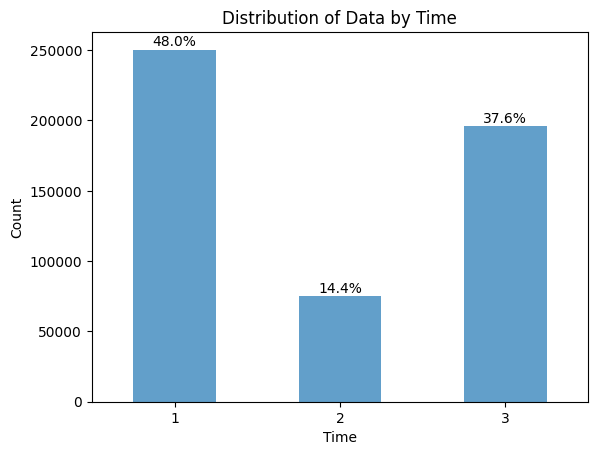

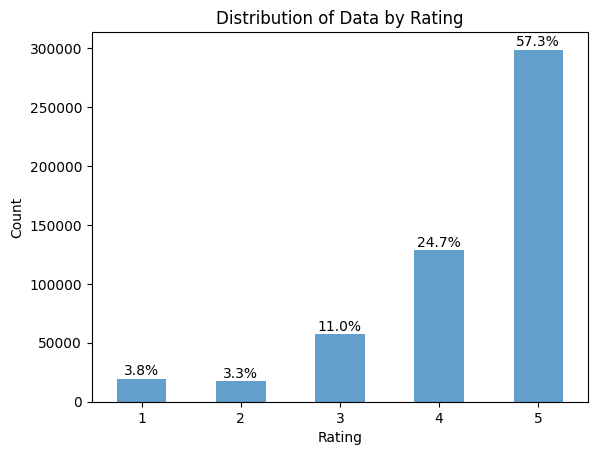

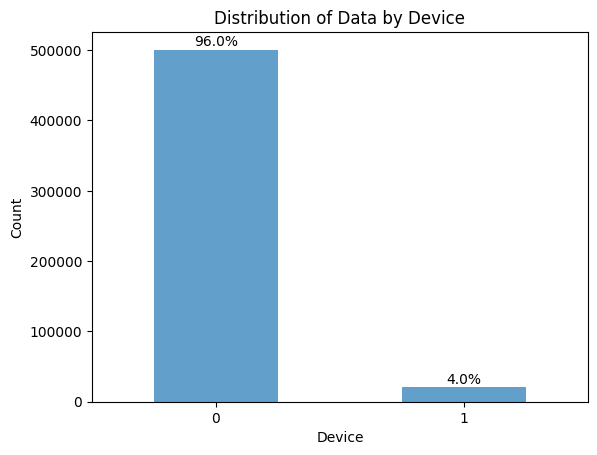

In [68]:
# Histogram for data distribution by time
counts = data_modified['time'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Distribution of Data by Time')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

# Histogram for data distribution by rating
counts = data_modified['rating'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Data by Rating')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

# Histogram for data distribution by devices
counts = data_modified['device'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Device')
plt.ylabel('Count')
plt.title('Distribution of Data by Device')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

In [69]:
print(data_modified.isnull().sum())

time      0
rating    0
device    0
dtype: int64


### Chi-square

In [70]:
# Chi-square test for 'time' and 'device'
chi2_time_device, p_time_device, dof_time_device, expected_time_device = stats.chi2_contingency(pd.crosstab(data_modified['time'], data_modified['device']))
print("Chi-square test result for 'time' and 'device':")
print("Chi-square statistic:", chi2_time_device)
print("P-value:", p_time_device)

Chi-square test result for 'time' and 'device':
Chi-square statistic: 77.89168097553406
P-value: 1.2190917242198965e-17


In [71]:
# Chi-square test for 'rating' and 'device'
chi2_rating_device, p_rating_device, dof_rating_device, expected_rating_device = stats.chi2_contingency(pd.crosstab(data_modified['rating'], data_modified['device']))
print("\nChi-square test result for 'rating' and 'device':")
print("Chi-square statistic:", chi2_rating_device)
print("P-value:", p_rating_device)


Chi-square test result for 'rating' and 'device':
Chi-square statistic: 2611.3884589742765
P-value: 0.0


In [72]:
# Chi-square test for 'rating' and 'time'
chi2_rating_time, p_rating_time, dof_rating_time, expected_rating_time = stats.chi2_contingency(pd.crosstab(data_modified['rating'], data_modified['time']))
print("\nChi-square test result for 'rating' and 'time':")
print("Chi-square statistic:", chi2_rating_time)
print("P-value:", p_rating_time)


Chi-square test result for 'rating' and 'time':
Chi-square statistic: 470.5512843830127
P-value: 1.4561827422400162e-96


The results of the chi-square test indicate that there is some degree of correlation between all three variables.

### Correlation Matrix

In [76]:
data_modified['time'] = data_modified['time'].astype(int)
corr_matrix = data_modified.corr()

print(corr_matrix)


            time    rating    device
time    1.000000  0.005652  0.002651
rating  0.005652  1.000000  0.064005
device  0.002651  0.064005  1.000000


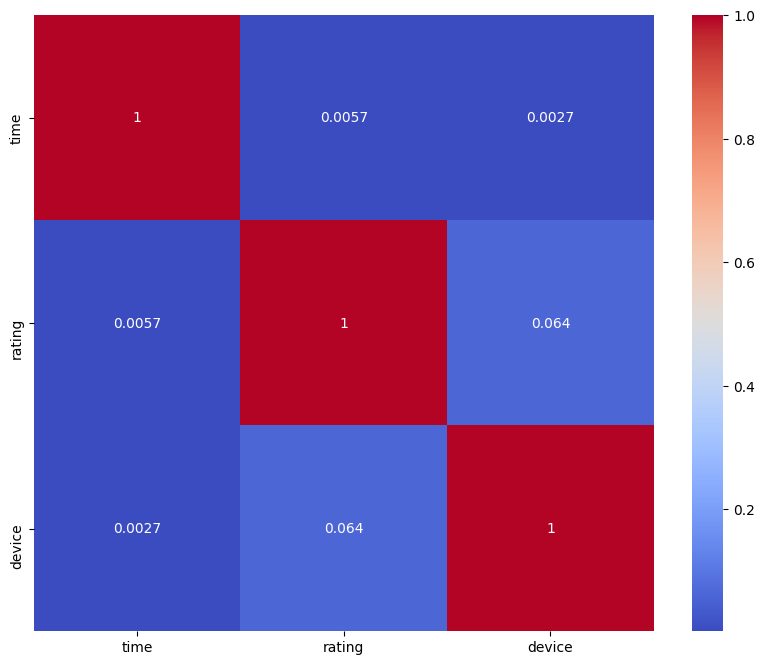

In [83]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


### Multicollinearity test

In [57]:
X = data_modified[['time', 'rating', 'device']]
vif_data = pd.DataFrame()
vif_data['Features'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nMulticollinearity test:")
print(vif_data)


Multicollinearity test:
  Features       VIF
0     time  4.272621
1   rating  4.321498
2   device  1.045736


The Variance Inflation Factors (VIF) for the 'time', 'rating', and 'device' variables are 4.27, 4.32, and 1.05 respectively. Typically, a VIF value greater than 5 or 10 indicates high multicollinearity. Here, none of the VIF values exceed these thresholds, suggesting that multicollinearity is not a significant concern in this dataset.

Summary: In the data processing phase of this project, we first cleaned and transformed the data appropriately. We then performed exploratory data analysis to visualize the distribution of ratings across different times of day and devices. Next, we conducted chi-square tests which revealed significant associations between 'time', 'device', and 'rating'. Correlation Matrix then proved these associations are not linear. A Variance Inflation Factor (VIF) test confirmed that multicollinearity was not a significant concern. This prepared the data effectively for the subsequent modeling phase.

## Modeling

In [36]:
# as.factor()?

### Data Balancing

According to the "rating distribution", it can be seen that there is a significant data imbalance between the different ratings, and stratified sampling may not be able to address this issue. Therefore, we plan to employ undersampling as a strategy to achieve balance in the dataset.

In [37]:
# Separate features (X) and target variable (y)
X = data_modified.drop('rating', axis=1)
y = data_modified['rating']

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Create a new balanced dataframe
balanced_data = X_resampled.copy()
balanced_data['rating'] = y_resampled

# Check the balanced distribution of ratings
balanced_data['rating'].value_counts()


5    17239
4    17239
3    17239
2    17239
1    17239
Name: rating, dtype: int64

### Train and Test Sets

In [38]:
# Separate features (X) and target variable (y) in the balanced dataset
X = balanced_data.drop('rating', axis=1)
y = balanced_data['rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2221877)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (68956, 2) (68956,)
Testing set shape: (17239, 2) (17239,)


### Multiple Linear Regression

In [95]:
# Fit the linear regression model
model = LinearRegression()
result = model.fit(X_train, y_train)
predictions = model.predict(X_test)

# model evaluation
print('mean_squared_error : ', mean_squared_error(y_test, predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))

mean_squared_error :  1.9819354641403497
mean_absolute_error :  1.197340529740373


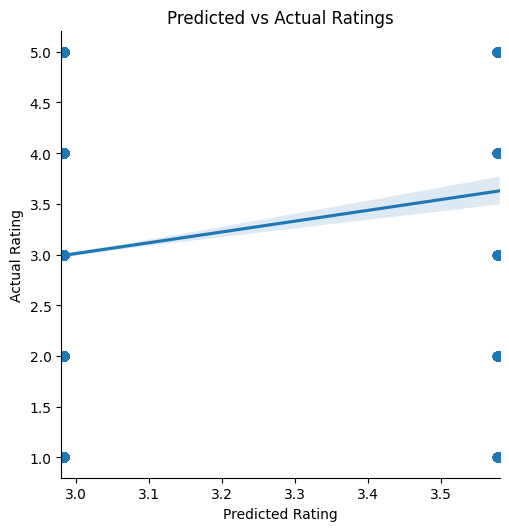

In [96]:
# Merge predictions and y_test into a single data frame
plot_regression = pd.DataFrame({'predictions': predictions, 'actual_rating': y_test})

# Create a scatter plot with linear regression line
sns.lmplot(x="predictions", y="actual_rating", data=plot_regression, scatter_kws={"alpha": 0.5})
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.title('Predicted vs Actual Ratings')
plt.show()

This plot does not form a significant linear relationship between the predicted and actual values, which confirms my previous correlation coefficient calculations that there is no significant linear relationship between my variables.

### Logistic Regression

Accuracy score:  0.20418817796855965
              precision    recall  f1-score   support

           1       0.20      0.51      0.28      3408
           2       0.00      0.00      0.00      3443
           3       0.20      0.47      0.28      3446
           4       0.00      0.00      0.00      3503
           5       0.40      0.05      0.09      3439

    accuracy                           0.20     17239
   macro avg       0.16      0.21      0.13     17239
weighted avg       0.16      0.20      0.13     17239



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


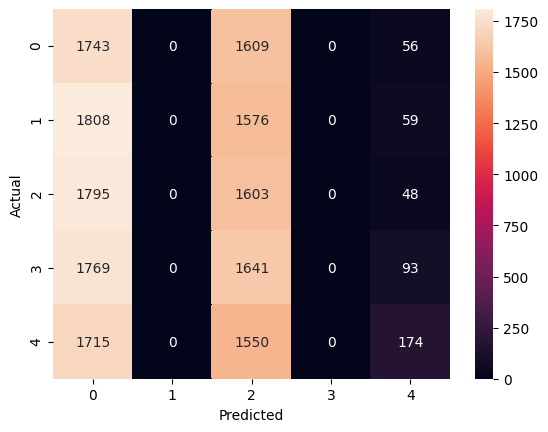

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 创建模型
model = LogisticRegression()

# 训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
predictions = model.predict(X_test)

# 评估模型
print('Accuracy score: ', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

# 可视化混淆矩阵
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [91]:
from sklearn.linear_model import LogisticRegression

# 创建多项逻辑回归模型，设置 multi_class 参数为 'multinomial'
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# 训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
predictions = model.predict(X_test)

# 评估模型
from sklearn.metrics import accuracy_score
print('Accuracy score: ', accuracy_score(y_test, predictions))


Accuracy score:  0.20418817796855965


### Polynomial Regression

In [88]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Fit the polynomial regression model
degree=2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_train, y_train)
predictions = polyreg.predict(X_test)

# Model evaluation
print('mean_squared_error : ', mean_squared_error(y_test, predictions))
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions))


mean_squared_error :  1.9814362660474985
mean_absolute_error :  1.1972560741038412


### Decision Tree

Accuracy score:  0.20824873832588897
              precision    recall  f1-score   support

           1       0.20      0.36      0.26      3408
           2       0.20      0.46      0.28      3443
           3       0.23      0.18      0.20      3446
           4       0.00      0.00      0.00      3503
           5       0.40      0.05      0.09      3439

    accuracy                           0.21     17239
   macro avg       0.21      0.21      0.16     17239
weighted avg       0.21      0.21      0.16     17239



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


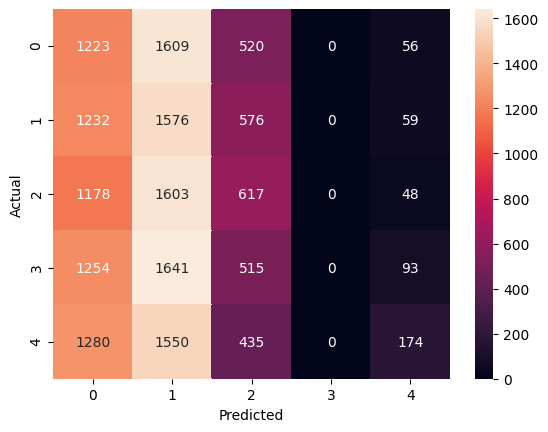

In [93]:
from sklearn.tree import DecisionTreeClassifier

# 创建模型
model = DecisionTreeClassifier()

# 训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
predictions = model.predict(X_test)

# 评估模型
print('Accuracy score: ', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

# 可视化混淆矩阵
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Random Forest

Accuracy score:  0.20824873832588897
              precision    recall  f1-score   support

           1       0.20      0.36      0.26      3408
           2       0.20      0.46      0.28      3443
           3       0.23      0.18      0.20      3446
           4       0.00      0.00      0.00      3503
           5       0.40      0.05      0.09      3439

    accuracy                           0.21     17239
   macro avg       0.21      0.21      0.16     17239
weighted avg       0.21      0.21      0.16     17239



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


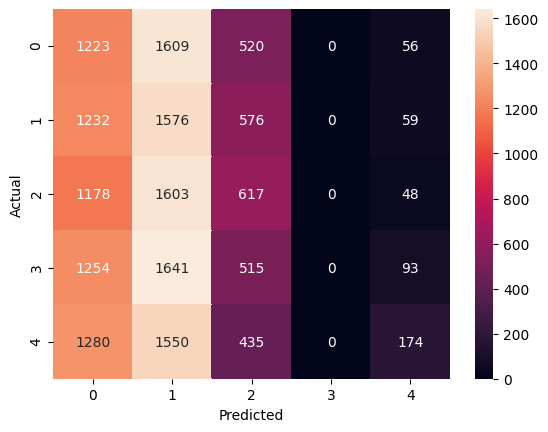

In [94]:
from sklearn.ensemble import RandomForestClassifier

# 创建模型
model = RandomForestClassifier()

# 训练模型
model.fit(X_train, y_train)

# 在测试集上进行预测
predictions = model.predict(X_test)

# 评估模型
print('Accuracy score: ', accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

# 可视化混淆矩阵
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Two-way ANOVA

In [39]:
# # Separate features (X) and target variable (y) in the balanced dataset
# X = balanced_data.drop('rating', axis=1)
# y = balanced_data['rating']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2221877)

# Combine the features and target variable into a single DataFrame
data_train = X_train.copy()
data_train['rating'] = y_train

# Define the formula
formula = 'rating ~ C(time) + C(pics)'

# Fit the model on the training set
model = ols(formula, data=data_train).fit()

# Perform ANOVA analysis on the training set
anova_results = sm.stats.anova_lm(model)
print(anova_results)

               df         sum_sq     mean_sq           F        PR(>F)
C(time)       2.0       4.973709    2.486855    1.248066  2.870658e-01
C(pics)       1.0     659.387440  659.387440  330.923734  9.005838e-74
Residual  68952.0  137391.423003    1.992566         NaN           NaN


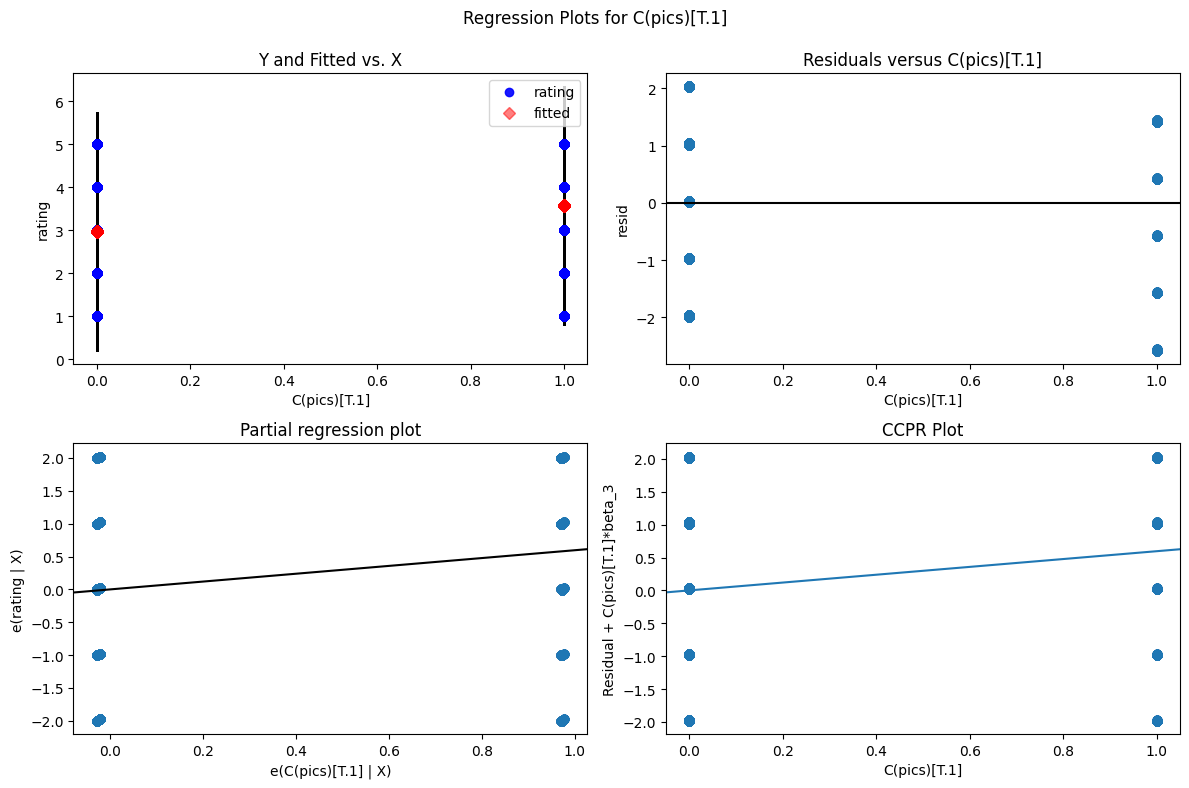

In [40]:
# Create the residual plot
fig = plt.figure(figsize=(12, 8))
plot_regress_exog(model, 'C(pics)[T.1]', fig=fig)

# Show the plot
plt.show()

Although the p-values of the two columns are very optimistic, the degrees of freedom of the residuals are too large.

### Linear Probability Model (OLS)

In [41]:
lpm_mod = sm.OLS(y_train, X_train)
lpm_res = lpm_mod.fit()
print("Parameters: ", lpm_res.params[:-1])

Parameters:  time    1.270059
dtype: float64


### Logit Model

In [42]:
# Mapping score values from 1-5 to a range between 0 and 1
y_train_mapped = np.interp(y_train, (1, 5), (0, 1))

# Model fitting using the mapped y_train_mapped
logit_mod = sm.Logit(y_train_mapped, X_train)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                68956
Model:                          Logit   Df Residuals:                    68954
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Jul 2023   Pseudo R-squ.:                0.002466
Time:                        19:13:02   Log-Likelihood:                -47679.
converged:                       True   LL-Null:                       -47797.
Covariance Type:            nonrobust   LLR p-value:                 3.318e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
time          -0.0082      0.004     -2.226      0.026      -0.015      -0.001
pics           0.6108      0.048     12.640      0.000       0.516       0.705


In [43]:
logit_res.pred_table()

array([[27103.,   524.],
       [39944.,  1385.]])

#### Marginal Effects

In [44]:
margeff = logit_res.get_margeff()
print(margeff.summary())


        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
time          -0.0020      0.001     -2.226      0.026      -0.004      -0.000
pics           0.1523      0.012     12.697      0.000       0.129       0.176


In [45]:
print(logit_res.summary())


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                68956
Model:                          Logit   Df Residuals:                    68954
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Jul 2023   Pseudo R-squ.:                0.002466
Time:                        19:13:02   Log-Likelihood:                -47679.
converged:                       True   LL-Null:                       -47797.
Covariance Type:            nonrobust   LLR p-value:                 3.318e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
time          -0.0082      0.004     -2.226      0.026      -0.015      -0.001
pics           0.6108      0.048     12.640      0.000       0.516       0.705


### Multinomial Logit

In [46]:
mlogit_mod = sm.MNLogit(y_train, X_train)
mlogit_res = mlogit_mod.fit()
print(mlogit_res.params)


Optimization terminated successfully.
         Current function value: 1.606484
         Iterations 5
             0         1         2         3
time -0.008983 -0.009500 -0.012414 -0.018653
pics  0.162383  0.022178  0.549131  1.135394


### Negative Binomial

In [48]:
mod_nbin = sm.NegativeBinomial(y_train, X_train)
res_nbin = mod_nbin.fit(disp=False)
print(res_nbin.summary())


c:\Python38\lib\site-packages\statsmodels\discrete\discrete_model.py:3737: RuntimeWarning: invalid value encountered in log
  start_params[-1] = np.log(start_params[-1])


                     NegativeBinomial Regression Results                      
Dep. Variable:                 rating   No. Observations:                68956
Model:               NegativeBinomial   Df Residuals:                    68954
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Jul 2023   Pseudo R-squ.:                     nan
Time:                        19:17:45   Log-Likelihood:            -1.4338e+05
converged:                       True   LL-Null:                           nan
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.4425      0.001    398.742      0.000       0.440       0.445
pics           0.3724      0.013     27.980      0.000       0.346       0.399
alpha          0.0414      0.002     17.341      0.0

c:\Python38\lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Python38\lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


### Alternative solvers

In [49]:
mlogit_res = mlogit_mod.fit(method="bfgs", maxiter=250)
print(mlogit_res.summary())


Optimization terminated successfully.
         Current function value: 1.606484
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
                          MNLogit Regression Results                          
Dep. Variable:                 rating   No. Observations:                68956
Model:                        MNLogit   Df Residuals:                    68948
Method:                           MLE   Df Model:                            4
Date:                Thu, 27 Jul 2023   Pseudo R-squ.:                0.001834
Time:                        19:17:48   Log-Likelihood:            -1.1078e+05
converged:                       True   LL-Null:                   -1.1098e+05
Covariance Type:            nonrobust   LLR p-value:                 8.420e-87
  rating=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
time          -0.0090      0.006     -

### Model Comparisons

(plots?)